<a href="https://colab.research.google.com/github/lisahligono/short-demo/blob/main/Ligono_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deep learning Project 2023-2024**
Author: Lisah Khadiala Ligono




In [ ]:
# Necessary libraries for the project
import numpy as np
import os
import folium
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## **Introduction**
For this project my area of study was the South of France abbreveated as *FR2*. Below is a map showing the area of interest covered with the red bounding box.

In [ ]:
# My area of study
FR2_Lisah = [(1.0, 43.0), (2.0, 44.0)]
lat = (FR2_Lisah[0][1] + FR2_Lisah[1][1]) / 2
lon = (FR2_Lisah[0][0] + FR2_Lisah[1][0]) / 2
aoi = folium.Map(location=[lat, lon], zoom_start=5)
folium.Polygon(locations=[(FR2_Lisah[0][1], FR2_Lisah[0][0]),
                           (FR2_Lisah[1][1], FR2_Lisah[0][0]),
                           (FR2_Lisah[1][1], FR2_Lisah[1][0]),
                           (FR2_Lisah[0][1], FR2_Lisah[1][0]),
                           (FR2_Lisah[0][1], FR2_Lisah[0][0])],
               color='red', fill=True, fill_color='red', fill_opacity=0.2).add_to(aoi)
aoi

## **Data**
I loaded the data as per the guidance provided in the assignment document.

In [ ]:
data_path = "/content/drive/MyDrive/FR2_DL/data_FR2.npz"

# Loading the data
data = np.load(data_path, allow_pickle=True)

series = data['series']
labels = data['labels']
dates = data['dates']
class_names = data['class_names']

## **Data characteristics**
The following section is set to answer the following questions:
- Identify the learning task to be solved
- Determine the number of features in the dataset and their type
- Look at the descriptive statistics for quantitative explanatory variables
- If you think it is necessary, normalize the data
- Look at the class distribution
- Based on your analysis, choose the cost function you will use to train your deep learning models

In [ ]:
# Determining the number of features using the 'shape' attribute
m, l, d = series.shape

print(f"Number of time series (m): {m}")
print(f"Length of time series (l): {l}")
print(f"Number of channels in the images (d): {d}")

Number of time series (m): 89985
Length of time series (l): 39
Number of channels in the images (d): 10


In [ ]:
# Checking the data type of the features
feature_type = series.dtype
print(f"Data type: {feature_type}")

Data type: float64


In [ ]:
print(class_names)
class_names.shape

['corn' 'horsebeans' 'meadow' 'spring_barley' 'spring_oat' 'spring_peas'
 'spring_rapeseed' 'spring_rye' 'spring_triticale' 'spring_wheat'
 'sunflowers' 'unknown' 'winter_barley' 'winter_oat' 'winter_peas'
 'winter_rapeseed' 'winter_rye' 'winter_triticale' 'winter_wheat']


(19,)

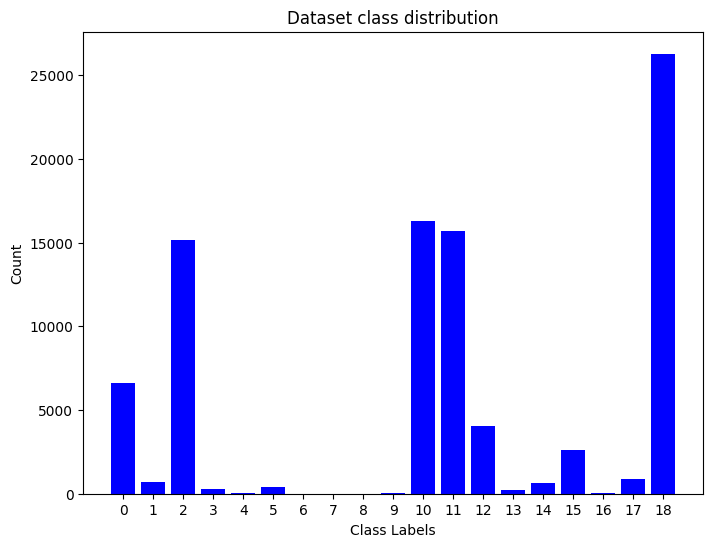

In [ ]:
# Calculate class distribution
unique_classes, class_counts = np.unique(labels, return_counts=True)

# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts, color='blue')
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Dataset class distribution')
plt.xticks(unique_classes)
plt.show()

The graph above shows the dataset distribution for each class. We can identify that class 18 has the highest number of datasets while class 6, 7, 8 having almost negligible datasets.

1. I have established that this is a ***classification*** task that involves classifying crop-types
2. By establishing this fact, the cost function that I will use is the CrossEntropy Loss Function since this multi-class classification.

# **Data preparation**
To prepare the data for analysis, I did a train-test split on the dataset as expalined below:

In [ ]:
# Defining the proportions for train, validation, and test sets
train_size = 0.8  # 80% of the data for training
val_size = 0.1    # 10% of the data for validation
test_size = 0.1   # 10% of the data for testing

# Splitting the data into train, validation, and test sets
series_train, series_temp, labels_train, labels_temp = train_test_split(
    series, labels, test_size=(val_size + test_size), random_state=42)
series_val, series_test, labels_val, labels_test = train_test_split(
    series_temp, labels_temp, test_size=(test_size / (val_size + test_size)), random_state=42)

print("Train set shapes:", series_train.shape, labels_train.shape)
print("Validation set shapes:", series_val.shape, labels_val.shape)
print("Test set shapes:", series_test.shape, labels_test.shape)


Train set shapes: (71988, 39, 10) (71988,)
Validation set shapes: (8998, 39, 10) (8998,)
Test set shapes: (8999, 39, 10) (8999,)


# **Deep learning models**
**Question**: You should implement and test a multi-layer perceptron (MLP), and compare it to one or two other models that take into account the temporal structure of the data (e.g., 1D-convolutional neural network or recurrent neural networks). For each model, you must justify the architectures used and explain how you have tuned the values for the various hyper-parameters.


## **MLP**
###***Architecture Choices***:
- I flattened the input layer into a flat ector since this is a multi-dimensional dataset `m,l,d: 89985, 39,10` before inputing it to the MLP.


- I chose two hidden layers (fc1 and fc2) used with the ReLU activation functions (nn.ReLU()). The choice of ReLU is because it introduces non-linearity and helps the network learn complex patterns.

- The output layer (fc3) uses the number of classes as the output size, and it has a softmax activation function since this is a multi-class classification.

###***Hyperparameter Tuning***:
- I chose 2 hidden layers due to the time-constraint and I did not want to build a very complex model.

- I chose a learning rate of 0.001 arbitrarily and the model was converging thus retaining the value

- I first set the number of epochs to `10` in order to quickly view how the model was behaving. I later increased it progressively to `50` since this was the threshold that was giving me a smooth loss function curve.

In [ ]:
# Converting the data to PyTorch tensors
series_train_tensor = torch.tensor(series_train, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.long)
series_val_tensor = torch.tensor(series_val, dtype=torch.float32)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.long)
series_test_tensor = torch.tensor(series_test, dtype=torch.float32)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.long)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [ ]:
# Setting the hyperparameters
input_size = series_train.shape[1] * series_train.shape[2]
hidden_size1 = 64
hidden_size2 = 32
output_size = len(class_names)
learning_rate = 0.001
epochs = 50

# Instantiating the model, loss function, and optimizer
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Lists to store training and validation loss and accuracy
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(series_train_tensor)
    loss = criterion(outputs, labels_train_tensor)
    loss.backward()
    optimizer.step()

#Training accuracy
    _, predicted_train = torch.max(outputs, 1)
    accuracy_train_mlp = accuracy_score(labels_train_tensor.numpy(), predicted_train.numpy())

# Validation
    with torch.no_grad():
        model.eval()
        outputs_val = model(series_val_tensor)
        loss_val = criterion(outputs_val, labels_val_tensor)
        _, predicted_val = torch.max(outputs_val, 1)
        accuracy_val_mlp = accuracy_score(labels_val_tensor.numpy(), predicted_val.numpy())

# Append to lists
    train_loss_list.append(loss.item())
    val_loss_list.append(loss_val.item())
    train_acc_list.append(accuracy_train_mlp)
    val_acc_list.append(accuracy_val_mlp)

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.3f}, Validation Loss: {loss_val.item():.3f}, '
              f'Training Accuracy: {accuracy_train_mlp:.3f}, Validation Accuracy: {accuracy_val_mlp:.3f}')

Epoch [1/50], Loss: 10.220, Validation Loss: 10.073, Training Accuracy: 0.459, Validation Accuracy: 0.469
Epoch [2/50], Loss: 10.111, Validation Loss: 9.975, Training Accuracy: 0.464, Validation Accuracy: 0.466
Epoch [3/50], Loss: 10.019, Validation Loss: 9.717, Training Accuracy: 0.460, Validation Accuracy: 0.462
Epoch [4/50], Loss: 9.757, Validation Loss: 9.518, Training Accuracy: 0.456, Validation Accuracy: 0.456
Epoch [5/50], Loss: 9.543, Validation Loss: 9.391, Training Accuracy: 0.454, Validation Accuracy: 0.457
Epoch [6/50], Loss: 9.395, Validation Loss: 9.122, Training Accuracy: 0.456, Validation Accuracy: 0.466
Epoch [7/50], Loss: 9.122, Validation Loss: 8.782, Training Accuracy: 0.465, Validation Accuracy: 0.478
Epoch [8/50], Loss: 8.801, Validation Loss: 8.589, Training Accuracy: 0.472, Validation Accuracy: 0.477
Epoch [9/50], Loss: 8.628, Validation Loss: 8.415, Training Accuracy: 0.471, Validation Accuracy: 0.471
Epoch [10/50], Loss: 8.457, Validation Loss: 8.114, Training

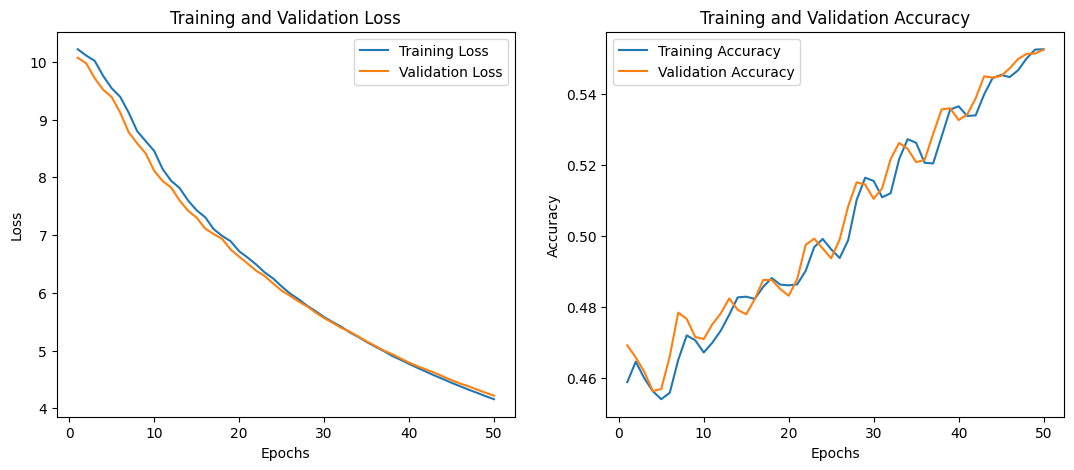

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss_list, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_acc_list, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluation on the test set
with torch.no_grad():
    model.eval()
    outputs_test = model(series_test_tensor)
    _, predicted_test = torch.max(outputs_test, 1)
    accuracy_test_mlp = accuracy_score(labels_test_tensor.numpy(), predicted_test.numpy())
    print(f'Accuracy on the test set: {accuracy_test_mlp:.3f}')

Accuracy on the test set: 0.549


# **Recurrent Neural Network**

For my second model, I chose the RNN

###***Architecture Choices:***

- I also chose 2 layers here in order to fairly compare the performance with that of the MLP.

###***Hyperparameter Tuning:***

- I chose the same hyperparameters as those of the MLP architectures so as to fairly evaluate the two models.

In [ ]:
input_size = series_train.shape[2]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1, :, :])
        return out

In [ ]:
# Settin the hyperparameters
hidden_size = 64
num_layers = 2
output_size = len(class_names)
learning_rate = 0.001
epochs = 50
batch_size = 32

model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# I decided to train the data in batches because the model kept crashing
train_loader = DataLoader(dataset=list(zip(series_train_tensor, labels_train_tensor)), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=list(zip(series_val_tensor, labels_val_tensor)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=list(zip(series_test_tensor, labels_test_tensor)), batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(epochs):
    model.train()
    for batch_series, batch_labels in train_loader:
        batch_series, batch_labels = batch_series.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_series)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.3f}')

Epoch [1/50], Loss: 1.499
Epoch [2/50], Loss: 1.108
Epoch [3/50], Loss: 0.961
Epoch [4/50], Loss: 0.663
Epoch [5/50], Loss: 0.775
Epoch [6/50], Loss: 1.206
Epoch [7/50], Loss: 0.921
Epoch [8/50], Loss: 1.185
Epoch [9/50], Loss: 0.482
Epoch [10/50], Loss: 0.682
Epoch [11/50], Loss: 0.861
Epoch [12/50], Loss: 0.991
Epoch [13/50], Loss: 0.777
Epoch [14/50], Loss: 1.349
Epoch [15/50], Loss: 1.030
Epoch [16/50], Loss: 0.657
Epoch [17/50], Loss: 0.767
Epoch [18/50], Loss: 1.025
Epoch [19/50], Loss: 0.539
Epoch [20/50], Loss: 0.486
Epoch [21/50], Loss: 1.063
Epoch [22/50], Loss: 0.920
Epoch [23/50], Loss: 0.486
Epoch [24/50], Loss: 0.836
Epoch [25/50], Loss: 0.816
Epoch [26/50], Loss: 0.841
Epoch [27/50], Loss: 0.646
Epoch [28/50], Loss: 0.391
Epoch [29/50], Loss: 0.957
Epoch [30/50], Loss: 0.834
Epoch [31/50], Loss: 0.844
Epoch [32/50], Loss: 0.602
Epoch [33/50], Loss: 0.519
Epoch [34/50], Loss: 0.687
Epoch [35/50], Loss: 0.856
Epoch [36/50], Loss: 0.956
Epoch [37/50], Loss: 1.004
Epoch [38/

In [ ]:
# Calculating training accuracy
model.eval()
all_train_labels = []
all_train_predictions = []
for batch_series, batch_labels in train_loader:
        batch_series, batch_labels = batch_series.to(device), batch_labels.to(device)
        outputs_train = model(batch_series)
        _, predicted_train = torch.max(outputs_train, 1)

        all_train_labels.extend(batch_labels.cpu().numpy())
        all_train_predictions.extend(predicted_train.cpu().numpy())
        accuracy_train_rnn = accuracy_score(all_train_labels, all_train_predictions)

In [ ]:
# Evaluation on the validation set
with torch.no_grad():
    model.eval()
    all_val_labels = []
    all_val_predictions = []
    for batch_series, batch_labels in val_loader:
        batch_series, batch_labels = batch_series.to(device), batch_labels.to(device)
        outputs_val = model(batch_series)
        _, predicted_val = torch.max(outputs_val, 1)

        all_val_labels.extend(batch_labels.cpu().numpy())
        all_val_predictions.extend(predicted_val.cpu().numpy())

    accuracy_val_rnn = accuracy_score(all_val_labels, all_val_predictions)
    print(f'Accuracy on the validation set: {accuracy_val_rnn:.3f}')

Accuracy on the validation set: 0.826


In [ ]:
# Evaluation on the test set
with torch.no_grad():
    model.eval()
    all_test_labels = []
    all_test_predictions = []
    for batch_series, batch_labels in test_loader:
        batch_series, batch_labels = batch_series.to(device), batch_labels.to(device)
        outputs_test = model(batch_series)
        _, predicted_test = torch.max(outputs_test, 1)

        all_test_labels.extend(batch_labels.cpu().numpy())
        all_test_predictions.extend(predicted_test.cpu().numpy())

    accuracy_test_rnn = accuracy_score(all_test_labels, all_test_predictions)
    print(f'Accuracy on the test set: {accuracy_test_rnn:.3f}')

Accuracy on the test set: 0.84


# **Performance**
You must compare the performance of the implemented deep learning models. To this end, you must explain how you evaluated the performance to ensure a fair comparison.

In [ ]:
data = {'Model': ['MLP', 'RNN'],
        'Training Accuracy': [accuracy_train_mlp, accuracy_train_rnn],
        'Testing Accuracy': [accuracy_test_mlp, accuracy_test_rnn]}
performance = pd.DataFrame(data)
performance.index = [''] * len(performance)
performance

,Model,Training Accuracy,Testing Accuracy
,MLP,0.552662,0.549061
,RNN,0.838737,0.836204


###***Training Accuracy***
The MLP model achieved a training accuracy of 55.27%, while the RNN model outperformed the MLP on the training set, achieving a significantly higher accuracy of 83.87%. This in my opinion suggests that the RNN captured more complex patterns in the training data.
###***Testing Accuracy***
The MLP model had a testing accuracy of 54.91%, while the RNN model achieved 83.62%.
